In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from xgboost import plot_importance
import smote_variants as sv
import sklearn.datasets as datasets

In [2]:
#Read dataset
df = pd.read_csv('./data/IoT Network Intrusion Dataset.csv')

In [3]:
df

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,...,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat,Sub_Cat
0,192.168.0.13-192.168.0.16-10000-10101-17,192.168.0.13,10000,192.168.0.16,10101,17,25/07/2019 03:25:53 AM,75,1,1,...,0.0,0.0,0.0,75.0,0.000000,75.0,75.0,Anomaly,Mirai,Mirai-Ackflooding
1,192.168.0.13-222.160.179.132-554-2179-6,222.160.179.132,2179,192.168.0.13,554,6,26/05/2019 10:11:06 PM,5310,1,2,...,0.0,0.0,0.0,2655.0,2261.327486,4254.0,1056.0,Anomaly,DoS,DoS-Synflooding
2,192.168.0.13-192.168.0.16-9020-52727-6,192.168.0.16,52727,192.168.0.13,9020,6,11/07/2019 01:24:48 AM,141,0,3,...,0.0,0.0,0.0,70.5,0.707107,71.0,70.0,Anomaly,Scan,Scan Port OS
3,192.168.0.13-192.168.0.16-9020-52964-6,192.168.0.16,52964,192.168.0.13,9020,6,04/09/2019 03:58:17 AM,151,0,2,...,0.0,0.0,0.0,151.0,0.000000,151.0,151.0,Anomaly,Mirai,Mirai-Hostbruteforceg
4,192.168.0.1-239.255.255.250-36763-1900-17,192.168.0.1,36763,239.255.255.250,1900,17,10/09/2019 01:41:18 AM,153,2,1,...,0.0,0.0,0.0,76.5,0.707107,77.0,76.0,Anomaly,Mirai,Mirai-Hostbruteforceg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625778,192.168.0.24-210.89.164.90-56112-8043-17,192.168.0.24,56112,210.89.164.90,8043,17,25/07/2019 03:25:00 AM,277,1,1,...,0.0,0.0,0.0,277.0,0.000000,277.0,277.0,Anomaly,Mirai,Mirai-UDP Flooding
625779,192.168.0.13-222.131.171.244-554-4570-6,222.131.171.244,4570,192.168.0.13,554,6,26/05/2019 10:06:51 PM,1658,0,2,...,0.0,0.0,0.0,1658.0,0.000000,1658.0,1658.0,Anomaly,DoS,DoS-Synflooding
625780,192.168.0.13-192.168.0.16-9020-52739-6,192.168.0.16,52739,192.168.0.13,9020,6,11/07/2019 01:29:09 AM,77,1,1,...,0.0,0.0,0.0,77.0,0.000000,77.0,77.0,Anomaly,Scan,Scan Port OS
625781,192.168.0.13-192.168.0.16-9020-49784-6,192.168.0.13,9020,192.168.0.16,49784,6,20/05/2019 05:00:29 AM,240,2,1,...,0.0,0.0,0.0,120.0,7.071068,125.0,115.0,Normal,Normal,Normal


In [4]:
df.Src_IP.value_counts()

192.168.0.13       222096
192.168.0.16       125890
192.168.0.24       122846
104.118.134.215     46092
104.74.213.186      23308
                    ...  
111.246.29.11           1
222.63.54.185           1
222.136.12.181          1
111.76.36.36            1
222.131.171.244         1
Name: Src_IP, Length: 57985, dtype: int64

In [5]:


# 选择你关注的类别特征
category_feature = 'Cat'

# 对数据集按照类别特征进行分组
grouped_data = df.groupby(category_feature)

# 计算每个分组的缺失值数量
# missing_values_count_by_group = grouped_data.apply(lambda g: g.isnull().sum())
missing_values_count_by_group = grouped_data.apply(lambda g: g.isnull().any(axis=1).sum())
# # 输出每个类别的缺失值数量
# print("每个类别的缺失值数量：")
print(missing_values_count_by_group)
# with open('missing_values_count_by_group.txt', 'w') as f:
#     f.write("每个类别的缺失值数量：\n")
#     f.write(str(missing_values_count_by_group))

Cat
DoS                  0
MITM ARP Spoofing    0
Mirai                0
Normal               0
Scan                 0
dtype: int64


In [6]:
cols = (df.dtypes=='object')
object_cols = list(cols[cols].index)
object_cols

['Flow_ID', 'Src_IP', 'Dst_IP', 'Timestamp', 'Label', 'Cat', 'Sub_Cat']

In [7]:
x=[0,1,3,85]
df.drop(df.columns[x], axis = 1, inplace=True)
df.drop('Timestamp', axis=1, inplace = True)

In [8]:
df

,Src_Port,Dst_Port,Protocol,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,...,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat
0,10000,10101,17,75,1,1,982.0,1430.0,982.0,982.0,...,0.0,0.0,0.0,0.0,75.0,0.000000,75.0,75.0,Anomaly,Mirai
1,2179,554,6,5310,1,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2655.0,2261.327486,4254.0,1056.0,Anomaly,DoS
2,52727,9020,6,141,0,3,0.0,2806.0,0.0,0.0,...,0.0,0.0,0.0,0.0,70.5,0.707107,71.0,70.0,Anomaly,Scan
3,52964,9020,6,151,0,2,0.0,2776.0,0.0,0.0,...,0.0,0.0,0.0,0.0,151.0,0.000000,151.0,151.0,Anomaly,Mirai
4,36763,1900,17,153,2,1,886.0,420.0,452.0,434.0,...,0.0,0.0,0.0,0.0,76.5,0.707107,77.0,76.0,Anomaly,Mirai
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625778,56112,8043,17,277,1,1,18.0,18.0,18.0,18.0,...,0.0,0.0,0.0,0.0,277.0,0.000000,277.0,277.0,Anomaly,Mirai
625779,4570,554,6,1658,0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1658.0,0.000000,1658.0,1658.0,Anomaly,DoS
625780,52739,9020,6,77,1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,77.0,0.000000,77.0,77.0,Anomaly,Scan
625781,9020,49784,6,240,2,1,2776.0,1388.0,1388.0,1388.0,...,0.0,0.0,0.0,0.0,120.0,7.071068,125.0,115.0,Normal,Normal


In [9]:
df.Cat.value_counts()

Mirai                415677
Scan                  75265
DoS                   59391
Normal                40073
MITM ARP Spoofing     35377
Name: Cat, dtype: int64

In [10]:
df.dtypes

Src_Port           int64
Dst_Port           int64
Protocol           int64
Flow_Duration      int64
Tot_Fwd_Pkts       int64
                  ...   
Idle_Std         float64
Idle_Max         float64
Idle_Min         float64
Label             object
Cat               object
Length: 81, dtype: object

In [11]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

In [12]:


# 计算每个特征的缺失值数量
missing_values_count = df.isnull().sum()

# 计算数据集中的缺失值总数
total_missing_values = missing_values_count.sum()

print("缺失值总数：", total_missing_values)


缺失值总数： 0


In [13]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
df.iloc[:, -2] = labelencoder.fit_transform(df.iloc[:, -2])


In [14]:
df.Cat.value_counts()

2    415677
4     75265
0     59391
3     40073
1     35377
Name: Cat, dtype: int64

In [15]:
# df_minor = df[(df['Cat']==1)|(df['Cat']==3)]
# df_major = df.drop(df_minor.index)

In [16]:
# df_major.Cat.value_counts()

In [17]:
# X = df_major.drop(['Cat'],axis=1) 
# y = df_major.iloc[:, -1].values.reshape(-1,1)
# y=np.ravel(y)


In [18]:
X = df.drop(['Cat'],axis=1) 
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [19]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

In [20]:
klabel=kmeans.labels_
df['klabel']=klabel

In [21]:
df['klabel'].value_counts()

617    4303
692    4221
521    3857
209    3834
611    3618
       ... 
682       8
486       8
235       7
678       4
230       3
Name: klabel, Length: 991, dtype: int64

In [22]:
cols = list(df)
cols.insert(81, cols.pop(cols.index('Cat')))
df = df.loc[:, cols]

In [23]:
def typicalSampling(group):
    name = group.name
    frac = 0.04 
    return group.sample(frac=frac)

result = df.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [24]:
result['Cat'].value_counts()

2    16652
4     3005
0     2378
3     1591
1     1402
Name: Cat, dtype: int64

In [25]:
result

,Src_Port,Dst_Port,Protocol,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,...,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,klabel,Cat
244611,0.166896,-0.908473,-0.738205,-0.147973,-0.388765,0.435813,-0.491223,1.135676,-0.633481,-0.591889,...,-0.017052,-0.047774,-0.054003,-0.181974,-0.045443,-0.154733,-0.180787,0,0,2
558486,0.157026,-0.908473,-0.738205,-0.144255,-0.388765,0.435813,-0.491223,1.135676,-0.633481,-0.591889,...,-0.017052,-0.047774,-0.054003,-0.175822,-0.045443,-0.150197,-0.174058,0,0,2
413345,0.157026,-0.908473,-0.738205,-0.148831,-0.388765,0.435813,-0.491223,1.135676,-0.633481,-0.591889,...,-0.017052,-0.047774,-0.054003,-0.183394,-0.045443,-0.155779,-0.182340,0,0,2
293082,0.163660,-0.908473,-0.738205,-0.138822,-0.388765,0.435813,-0.491223,1.135676,-0.633481,-0.591889,...,-0.017052,-0.047774,-0.054003,-0.166830,-0.045443,-0.143569,-0.164223,0,0,2
418076,0.157026,-0.908473,-0.738205,-0.142253,-0.388765,0.435813,-0.491223,1.135676,-0.633481,-0.591889,...,-0.017052,-0.047774,-0.054003,-0.172509,-0.045443,-0.147755,-0.170435,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370019,-1.051984,2.070041,-0.738205,-0.158840,-0.156745,-0.384201,0.703399,0.264886,1.606761,1.768006,...,-0.017052,-0.047774,-0.054003,-0.199959,-0.045443,-0.167989,-0.200457,0,999,4
11702,-1.051984,2.070041,-0.738205,-0.159126,-0.156745,-0.384201,0.703399,0.264886,1.606761,1.768006,...,-0.017052,-0.047774,-0.054003,-0.200432,-0.045443,-0.168338,-0.200974,0,999,4
431396,-1.051984,2.070041,-0.738205,-0.157124,-0.156745,-0.384201,0.703399,0.264886,1.606761,1.768006,...,-0.017052,-0.047774,-0.054003,-0.197119,-0.045443,-0.165896,-0.197351,0,999,4
134775,-1.051984,2.070041,-0.738205,-0.158554,-0.156745,-0.384201,0.703399,0.264886,1.606761,1.768006,...,-0.017052,-0.047774,-0.054003,-0.199485,-0.045443,-0.167640,-0.199939,0,999,4


In [26]:
result = result.drop(['klabel'],axis=1)
#result = result.append(df_minor)

In [27]:
result['Cat'].value_counts()

2    16652
4     3005
0     2378
3     1591
1     1402
Name: Cat, dtype: int64

In [28]:
result.to_csv('./data/IoTID20_sample_km.csv',index=0)

In [55]:
df=pd.read_csv('./data/IoTID20_sample_km.csv')

In [56]:
X = df.drop(['Cat'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [58]:
# Prepare the result output
output_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Train_time', 'Predict_time_per_record', 'HPO_time'])
output_index = list()

In [59]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [60]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [61]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [62]:
X_fs = df[fs].values

In [63]:
X_fs.shape

(25028, 39)

In [64]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [65]:
import datetime
start = datetime.datetime.now()

In [66]:
X_fss = fcbf.fit_transform(X_fs,y)

In [67]:
end = datetime.datetime.now()
print("程序运行时间："+str((end-start).seconds)+"秒")

程序运行时间：13秒


In [68]:
X_fss.shape

(25028, 20)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [70]:
X_train.shape

(20022, 20)

In [71]:
pd.Series(y_train).value_counts()

2    13321
4     2404
0     1902
3     1273
1     1122
dtype: int64

In [75]:
y_train.shape

(20022,)

### SMOTE to solve class-imbalance

In [83]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# import smote_variants as sv
# import sklearn.datasets as datasets
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.ensemble import GradientBoostingClassifier

# #dataset= datasets.load_breast_cancer()

# dataset= {'data': X_train,
#           'target': y_train,
#           'name': 'IDS'}

# # classifiers = [('sklearn.neighbors', 'KNeighborsClassifier', {}),
# #               ('sklearn.tree', 'DecisionTreeClassifier', {})]
# classifiers = [
#     ('sklearn.neighbors', 'KNeighborsClassifier', {}),
#     ('sklearn.tree', 'DecisionTreeClassifier', {}),
#     ('sklearn.ensemble', 'RandomForestClassifier', {}),
#     ('sklearn.svm', 'SVC', {}),
#     ('sklearn.linear_model', 'LogisticRegression', {}),
#     ('sklearn.ensemble', 'AdaBoostClassifier', {}),
#     ('sklearn.ensemble', 'GradientBoostingClassifier', {})
# ]

# #oversamplers = sv.queries.get_all_oversamplers(n_quickest=2)
# oversamplers = [sv.polynom_fit_SMOTE_bus,
#                 sv.polynom_fit_SMOTE_mesh,
#                 sv.polynom_fit_SMOTE_poly,
#                 sv.polynom_fit_SMOTE_star]
# os_params = sv.queries.generate_parameter_combinations(oversamplers,
#                                                       n_max_comb=2)

# # samp_obj and cl_obj contain the oversampling and classifier objects which give the
# # best performance together
# samp_obj, cl_obj= sv.evaluation.model_selection(dataset=dataset,
#                                                 oversamplers=os_params,
#                                                 classifiers=classifiers,
#                                                 validator_params={'n_splits': 2,
#                                                                   'n_repeats': 1},
#                                                 n_jobs= 5)

# # training the best techniques using the entire dataset
# X_samp, y_samp= samp_obj.sample(X_train,
#                                 y_train)
# cl_obj.fit(X_samp, y_samp)

2023-03-25 18:06:43.392584: processing dataset: IDS


ValueError: y_true and y_pred contain different number of classes 5, 2. Please provide the true labels explicitly through the labels argument. Classes found in y_true: [0 1 2 3 4]

In [84]:


oversampler= sv.MulticlassOversampling(oversampler='polynom_fit_SMOTE_bus',
                                      oversampler_params={'random_state': 5})

# X_samp and y_samp contain the oversampled dataset
X_samp, y_samp= oversampler.sample(X_train, y_train)

2023-03-25 18:51:20,907:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2023-03-25 18:51:20,911:INFO:MulticlassOversampling: Sampling minority class with label: 4
2023-03-25 18:51:20,913:INFO:polynom_fit_SMOTE_bus: Running sampling via ('polynom_fit_SMOTE_bus', "{'proportion': 1.0, 'topology': 'bus', 'random_state': 5, 'class_name': 'polynom_fit_SMOTE_bus'}")
2023-03-25 18:51:20,914:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.0, 'topology': 'bus', 'random_state': 5, 'class_name': 'polynom_fit_SMOTE'}")
2023-03-25 18:51:20,942:INFO:MulticlassOversampling: Sampling minority class with label: 0
2023-03-25 18:51:20,945:INFO:polynom_fit_SMOTE_bus: Running sampling via ('polynom_fit_SMOTE_bus', "{'proportion': 0.46156022635408245, 'topology': 'bus', 'random_state': 5, 'class_name': 'polynom_fit_SMOTE_bus'}")
2023-03-25 18:51:20,947:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'

In [85]:
pd.Series(y_samp).value_counts()

4    14419
3    13993
1    13453
2    13321
0    13308
dtype: int64

# XGBoost

Accuracy of XGBoost: 0.9784258889332801
Precision of XGBoost: 0.9782680168145382
Recall of XGBoost: 0.9784258889332801
F1-score of XGBoost: 0.9780693745531226
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       476
           1       0.93      0.84      0.88       279
           2       0.98      1.00      0.99      3332
           3       1.00      0.98      0.99       321
           4       0.99      0.93      0.96       598

    accuracy                           0.98      5006
   macro avg       0.98      0.95      0.96      5006
weighted avg       0.98      0.98      0.98      5006



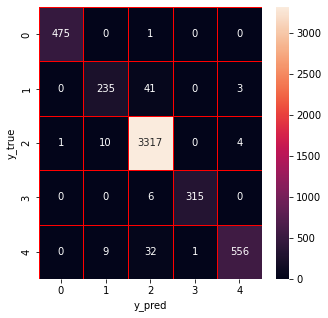

In [40]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### BO-TPE

In [41]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/trial, best loss: -0.9866160607271275]
XGBoost: Hyperopt estimated optimum {'learning_rate': -0.7389091535365018, 'max_depth': 26.0, 'n_estimators': 35.0}


Accuracy of XGBoost: 0.9866160607271275
Precision of XGBoost: 0.9866604395211346
Recall of XGBoost: 0.9866160607271275
F1-score of XGBoost: 0.986623766429528
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       476
           1       0.91      0.92      0.91       279
           2       0.99      0.99      0.99      3332
           3       1.00      0.98      0.99       321
           4       0.98      0.97      0.98       598

    accuracy                           0.99      5006
   macro avg       0.98      0.97      0.97      5006
weighted avg       0.99      0.99      0.99      5006



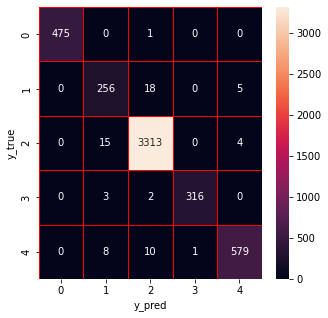

In [42]:
xg = xgb.XGBClassifier(learning_rate=0.7389091535365018, n_estimators = 35, max_depth = 26
                    )
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [43]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

# Random Forest 

Accuracy of RF: 0.979624450659209
Precision of RF: 0.9794429354960806
Recall of RF: 0.979624450659209
F1-score of RF: 0.9793899218152312
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       476
           1       0.92      0.86      0.89       279
           2       0.98      0.99      0.99      3332
           3       0.99      0.97      0.98       321
           4       0.98      0.94      0.96       598

    accuracy                           0.98      5006
   macro avg       0.97      0.95      0.96      5006
weighted avg       0.98      0.98      0.98      5006



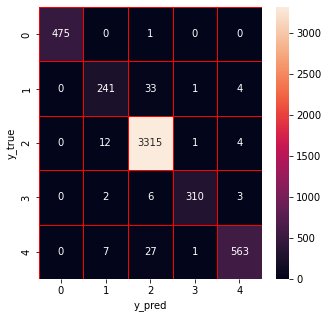

In [44]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### GA


In [47]:


#Random Forest
from tpot import TPOTClassifier
# Define the hyperparameter configuration space
parameters = {
        'n_estimators': range(20,200),
    "max_features":range(1,20),
    'max_depth': range(10,100),
    "min_samples_split":range(2,11),
    "min_samples_leaf":range(1,11),
    "criterion":['gini','entropy']
             }
# Set the hyperparameters of GA                 
ga2 = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.ensemble.RandomForestClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
ga2.fit(X, y)



C:\Users\FOCUS\.conda\envs\tf2\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


1 operators have been imported by TPOT.
                                                                                                                       
Generation 1 - Current Pareto front scores:
                                                                                                                       
-1	0.9322358684400801	RandomForestClassifier(CombineDFs(input_matrix, input_matrix), RandomForestClassifier__criterion=gini, RandomForestClassifier__max_depth=13, RandomForestClassifier__max_features=19, RandomForestClassifier__min_samples_leaf=7, RandomForestClassifier__min_samples_split=6, RandomForestClassifier__n_estimators=89)
                                                                                                                       
Generation 2 - Current Pareto front scores:
                                                                                                                       
-1	0.9322358684400801	RandomForestClassifier(CombineDFs(in

TPOTClassifier(config_dict={'sklearn.ensemble.RandomForestClassifier': {'criterion': ['gini',
                                                                                      'entropy'],
                                                                        'max_depth': range(10, 100),
                                                                        'max_features': range(1, 20),
                                                                        'min_samples_leaf': range(1, 11),
                                                                        'min_samples_split': range(2, 11),
                                                                        'n_estimators': range(20, 200)}},
               cv=3, early_stop=5, generations=3, offspring_size=5,
               population_size=10, scoring='accuracy', verbosity=3)

### PSO  RF

In [45]:
#Random Forest
import optunity
import optunity.metrics


# Define the hyperparameter configuration space
search = {
    'n_estimators': [100, 260],
    'max_features': [1, 20],
    'max_depth': [5,50],
    "min_samples_split":[2,11],
    "min_samples_leaf":[1,11],
    "criterion":[0,1]
         }
# Define the objective function
@optunity.cross_validated(x=X, y=y, num_folds=3)
def performance(x_train, y_train, x_test, y_test,n_estimators=None, max_features=None,max_depth=None,min_samples_split=None,min_samples_leaf=None,criterion=None):
    # fit the model
    if criterion<0.5:
        cri='gini'
    else:
        cri='entropy'
    model = RandomForestClassifier(n_estimators=int(n_estimators),
                                   max_features=int(max_features),
                                   max_depth=int(max_depth),
                                   min_samples_split=int(min_samples_split),
                                   min_samples_leaf=int(min_samples_leaf),
                                   criterion=cri,
                                  )
    #predictions = model.predict(x_test)
    scores=np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                    scoring="accuracy"))
    #return optunity.metrics.roc_auc(y_test, predictions, positive=True)
    return scores#optunity.metrics.accuracy(y_test, predictions)

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )
print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

{'n_estimators': 198.0625, 'max_features': 19.593838489042422, 'max_depth': 22.595703125, 'min_samples_split': 6.918359375, 'min_samples_leaf': 2.2343480215779783, 'criterion': 0.05648063003637588}
Accuracy:0.9344069151182374


### BO-TPE

In [45]:

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:47<00:00,  2.38s/trial, best loss: -0.9804234918098282]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 18.0, 'max_features': 7.0, 'min_samples_leaf': 2.0, 'min_samples_split': 5.0, 'n_estimators': 161.0}


## After HPO

Accuracy of RF: 0.9780263683579704
Precision of RF: 0.9778194484097114
Recall of RF: 0.9780263683579704
F1-score of RF: 0.9777316171234004
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       476
           1       0.90      0.84      0.87       279
           2       0.98      0.99      0.99      3332
           3       0.99      0.98      0.98       321
           4       0.99      0.94      0.96       598

    accuracy                           0.98      5006
   macro avg       0.97      0.95      0.96      5006
weighted avg       0.98      0.98      0.98      5006



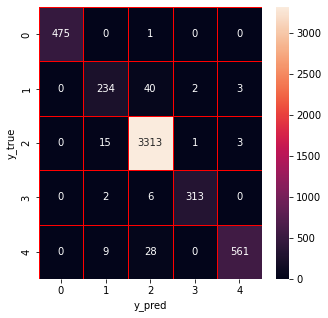

In [46]:

rf_hpo = RandomForestClassifier(n_estimators =161, min_samples_leaf = 2, max_depth =18,
                                min_samples_split = 5, max_features =7, criterion = 'gini')
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [47]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

# Decision Tree

Accuracy of DT: 0.9840191769876149
Precision of DT: 0.9842373397560988
Recall of DT: 0.9840191769876149
F1-score of DT: 0.9841066819128552
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       476
           1       0.89      0.92      0.90       281
           2       0.99      0.99      0.99      3330
           3       1.00      0.98      0.99       319
           4       0.98      0.98      0.98       600

    accuracy                           0.98      5006
   macro avg       0.97      0.97      0.97      5006
weighted avg       0.98      0.98      0.98      5006



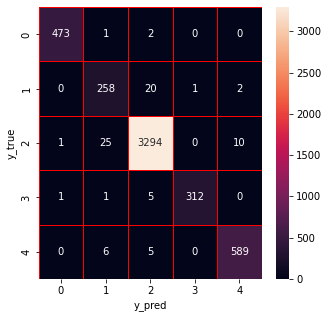

In [48]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### GA

In [51]:


#Random Forest
from tpot import TPOTClassifier
# Define the hyperparameter configuration space
parameters = {
    "max_features":range(1,20),
    'max_depth': range(5,50),
    "min_samples_split":range(2,11),
    "min_samples_leaf":range(1,11),
    "criterion":['gini','entropy']

             }
# Set the hyperparameters of GA                 
ga2 = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.tree.DecisionTreeClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
ga2.fit(X, y)



1 operators have been imported by TPOT.
                                                                                                                       
Generation 1 - Current Pareto front scores:
                                                                                                                       
-1	0.8846490791851437	DecisionTreeClassifier(input_matrix, DecisionTreeClassifier__criterion=entropy, DecisionTreeClassifier__max_depth=45, DecisionTreeClassifier__max_features=12, DecisionTreeClassifier__min_samples_leaf=10, DecisionTreeClassifier__min_samples_split=6)
                                                                                                                       
-2	0.90031247761228	DecisionTreeClassifier(DecisionTreeClassifier(input_matrix, DecisionTreeClassifier__criterion=entropy, DecisionTreeClassifier__max_depth=45, DecisionTreeClassifier__max_features=19, DecisionTreeClassifier__min_samples_leaf=1, DecisionTreeClassifier__min_samples_spl

TPOTClassifier(config_dict={'sklearn.tree.DecisionTreeClassifier': {'criterion': ['gini',
                                                                                  'entropy'],
                                                                    'max_depth': range(5, 50),
                                                                    'max_features': range(1, 20),
                                                                    'min_samples_leaf': range(1, 11),
                                                                    'min_samples_split': range(2, 11)}},
               cv=3, early_stop=5, generations=3, offspring_size=5,
               population_size=10, scoring='accuracy', verbosity=3)

### BO-TPE

In [49]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 50/50 [00:02<00:00, 18.95trial/s, best loss: -0.9844186975629244]
Decision tree: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 30.0, 'max_features': 18.0, 'min_samples_leaf': 1.0, 'min_samples_split': 5.0}


### PSO

In [50]:

import optunity
import optunity.metrics

data=X
labels=y
# Define the hyperparameter configuration space
search = {
    'max_features': [1, 20],
    'max_depth': [5,50],
    "min_samples_split":[2,11],
    "min_samples_leaf":[1,11],
    "criterion":[0,1]
         }
# Define the objective function
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test, max_features=None,max_depth=None,min_samples_split=None,min_samples_leaf=None,criterion=None):
    # fit the model
    if criterion<0.5:
        cri='gini'
    else:
        cri='entropy'
    model = DecisionTreeClassifier(
                                   max_features=int(max_features),
                                   max_depth=int(max_depth),
                                   min_samples_split=int(min_samples_split),
                                   min_samples_leaf=int(min_samples_leaf),
                                   criterion=cri,
                                  )
    #predictions = model.predict(x_test)
    scores=np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                    scoring="accuracy"))
    #return optunity.metrics.roc_auc(y_test, predictions, positive=True)
    return scores#optunity.metrics.accuracy(y_test, predictions)

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )
print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))

{'max_features': 16.22150343263128, 'max_depth': 33.25244140625, 'min_samples_split': 7.16708984375, 'min_samples_leaf': 6.0302734375, 'criterion': 0.51279296875}
Accuracy:0.8908821940128927


## After HPO

Accuracy of DT: 0.9830203755493407
Precision of DT: 0.9832799884441911
Recall of DT: 0.9830203755493407
F1-score of DT: 0.9831214482986241
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       476
           1       0.89      0.93      0.91       281
           2       0.99      0.99      0.99      3330
           3       0.98      0.97      0.98       319
           4       0.98      0.97      0.98       600

    accuracy                           0.98      5006
   macro avg       0.97      0.97      0.97      5006
weighted avg       0.98      0.98      0.98      5006



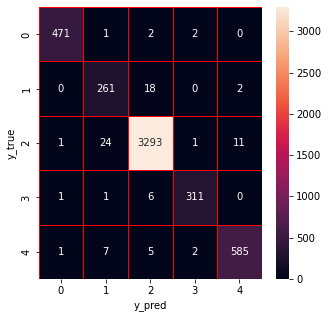

In [50]:

dt_hpo = DecisionTreeClassifier(min_samples_leaf = 1, max_depth = 30, min_samples_split = 5, 
                                max_features = 18, criterion = 'gini')
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [51]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

# Extra Trees

Accuracy of ET: 0.9772273272073512
Precision of ET: 0.9771197342557829
Recall of ET: 0.9772273272073512
F1-score of ET: 0.9771399982825544
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       476
           1       0.89      0.87      0.88       281
           2       0.98      0.99      0.98      3330
           3       0.99      0.96      0.98       319
           4       0.96      0.96      0.96       600

    accuracy                           0.98      5006
   macro avg       0.97      0.96      0.96      5006
weighted avg       0.98      0.98      0.98      5006



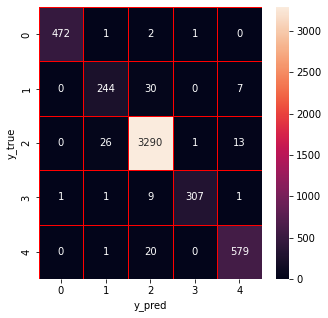

In [52]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### GA

In [55]:


#Random Forest
from tpot import TPOTClassifier
# Define the hyperparameter configuration space
parameters = {
    'n_estimators': range(10,200),
    "max_features":range(1,20),
    'max_depth': range(5,50),
    "min_samples_split":range(2,11),
    "min_samples_leaf":range(1,11),
    "criterion":['gini','entropy']
    
             }
# Set the hyperparameters of GA                 
ga2 = TPOTClassifier(generations= 3, population_size= 10, offspring_size= 5,
                                 verbosity= 3, early_stop= 5,
                                 config_dict=
                                 {'sklearn.ensemble.ExtraTreesClassifier': parameters}, 
                                 cv = 3, scoring = 'accuracy')
ga2.fit(X, y)



1 operators have been imported by TPOT.
                                                                                                                       
Generation 1 - Current Pareto front scores:
                                                                                                                       
-1	0.8430156956554228	ExtraTreesClassifier(input_matrix, ExtraTreesClassifier__criterion=gini, ExtraTreesClassifier__max_depth=47, ExtraTreesClassifier__max_features=16, ExtraTreesClassifier__min_samples_leaf=3, ExtraTreesClassifier__min_samples_split=6, ExtraTreesClassifier__n_estimators=33)
                                                                                                                       
-2	0.8521650775773802	ExtraTreesClassifier(ExtraTreesClassifier(CombineDFs(input_matrix, input_matrix), ExtraTreesClassifier__criterion=entropy, ExtraTreesClassifier__max_depth=13, ExtraTreesClassifier__max_features=9, ExtraTreesClassifier__min_samples_leaf=3, E

TPOTClassifier(config_dict={'sklearn.ensemble.ExtraTreesClassifier': {'criterion': ['gini',
                                                                                    'entropy'],
                                                                      'max_depth': range(5, 50),
                                                                      'max_features': range(1, 20),
                                                                      'min_samples_leaf': range(1, 11),
                                                                      'min_samples_split': range(2, 11),
                                                                      'n_estimators': range(10, 200)}},
               cv=3, early_stop=5, generations=3, offspring_size=5,
               population_size=10, scoring='accuracy', verbosity=3)

### BO-TPE

In [53]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:31<00:00,  1.56s/trial, best loss: -0.9864163004394726]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 46.0, 'max_features': 17.0, 'min_samples_leaf': 1.0, 'min_samples_split': 5.0, 'n_estimators': 38.0}


### PSO

In [54]:
import optunity
import optunity.metrics

data=X
labels=y
# Define the hyperparameter configuration space
search = {
    'n_estimators': [10,200],
    'max_features': [1, 20],
    'max_depth': [5,50],
    "min_samples_split":[2,11],
    "min_samples_leaf":[1,11],
    "criterion":[0,1]
         }
# Define the objective function
@optunity.cross_validated(x=data, y=labels, num_folds=3)
def performance(x_train, y_train, x_test, y_test, n_estimators=None,max_features=None,max_depth=None,min_samples_split=None,min_samples_leaf=None,criterion=None):
    # fit the model
    if criterion<0.5:
        cri='gini'
    else:
        cri='entropy'
    model = ExtraTreesClassifier(n_estimators=int(n_estimators),
                                   max_features=int(max_features),
                                   max_depth=int(max_depth),
                                   min_samples_split=int(min_samples_split),
                                   min_samples_leaf=int(min_samples_leaf),
                                   criterion=cri,
                                  )
    #predictions = model.predict(x_test)
    scores=np.mean(cross_val_score(model, X, y, cv=3, n_jobs=-1,
                                    scoring="accuracy"))
    #return optunity.metrics.roc_auc(y_test, predictions, positive=True)
    return scores#optunity.metrics.accuracy(y_test, predictions)

optimal_configuration, info, _ = optunity.maximize(performance,
                                                  solver_name='particle swarm',
                                                  num_evals=20,
                                                   **search
                                                  )
print(optimal_configuration)
print("Accuracy:"+ str(info.optimum))


{'n_estimators': 123.00435902209072, 'max_features': 18.003515625, 'max_depth': 34.021484375, 'min_samples_split': 9.83838127062509, 'min_samples_leaf': 3.18359375, 'criterion': 0.402734375}
Accuracy:0.8503937206994765


Accuracy of ET: 0.986016779864163
Precision of ET: 0.9859811516143199
Recall of ET: 0.986016779864163
F1-score of ET: 0.9859855596044618
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       476
           1       0.94      0.92      0.93       281
           2       0.99      0.99      0.99      3330
           3       0.99      0.97      0.98       319
           4       0.98      0.98      0.98       600

    accuracy                           0.99      5006
   macro avg       0.98      0.97      0.97      5006
weighted avg       0.99      0.99      0.99      5006



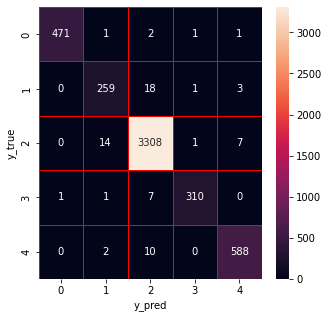

In [54]:

       
et_hpo = ExtraTreesClassifier(n_estimators = 38, min_samples_leaf = 1, max_depth =46, 
                              min_samples_split = 5, max_features = 17, criterion = 'gini')
et_hpo.fit(X_train,y_train) 
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [55]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

In [56]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,2,2,2,2
1,2,2,2,2
2,2,2,2,2
3,2,2,2,2
4,2,2,2,2


In [57]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [58]:
dt_train.shape

(20022, 1)

In [59]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.9890131841789852
Precision of Stacking: 0.9889833246636558
Recall of Stacking: 0.9890131841789852
F1-score of Stacking: 0.9889872688706302
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       476
           1       0.95      0.94      0.95       281
           2       0.99      1.00      0.99      3330
           3       0.99      0.98      0.98       319
           4       0.98      0.98      0.98       600

    accuracy                           0.99      5006
   macro avg       0.98      0.98      0.98      5006
weighted avg       0.99      0.99      0.99      5006



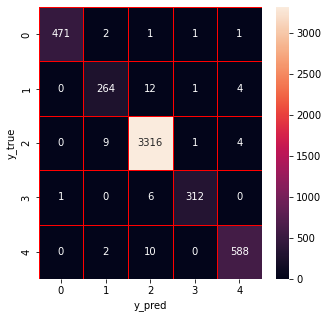

In [60]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [61]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|█████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.20trial/s, best loss: -0.98921294446664]
XGBoost: Hyperopt estimated optimum {'learning_rate': 1.7558125912383415, 'max_depth': 81.0, 'n_estimators': 90.0}


Accuracy of XGBoost: 0.98921294446664
Precision of XGBoost: 0.9892015042805775
Recall of XGBoost: 0.98921294446664
F1-score of XGBoost: 0.9891955557489782
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       476
           1       0.95      0.95      0.95       281
           2       0.99      1.00      0.99      3330
           3       0.99      0.98      0.98       319
           4       0.99      0.98      0.98       600

    accuracy                           0.99      5006
   macro avg       0.98      0.98      0.98      5006
weighted avg       0.99      0.99      0.99      5006



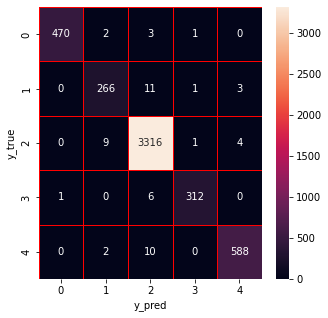

In [62]:
xg = xgb.XGBClassifier(learning_rate=1.7558125912383415, n_estimators =90 , max_depth = 81)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Anomaly-based IDS

### Generate the port-scan datasets for unknown attack detection

In [52]:
df=pd.read_csv('./data/IoTID20_sample_km.csv')

In [53]:
df.Cat.value_counts()

2    16652
4     3005
0     2378
3     1591
1     1402
Name: Cat, dtype: int64

In [54]:
df1 = df[df['Cat'] != 3]


df1.loc[df1['Cat'] != 2, 'Cat'] = 1



df1.to_csv('./data/IoTID20_sample_km_without_portscan.csv',index=0)

In [55]:
df2 = df[df['Cat'] == 3]

df2.loc[df2['Cat'] == 3, 'Cat'] = 1

df2.to_csv('./data/IoTID20_sample_km_portscan.csv',index=0)

In [70]:
df1 = pd.read_csv('./data/IoTID20_sample_km_without_portscan.csv')
df2 = pd.read_csv('./data/IoTID20_sample_km_portscan.csv')

In [71]:
features = df1.drop(['Cat'],axis=1).dtypes[df1.dtypes != 'object'].index
df1[features] = df1[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df2[features] = df2[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df1 = df1.fillna(0)
df2 = df2.fillna(0)

In [72]:
df1['Cat'][df1['Cat'] == 2] = 0



C:\Users\FOCUS\AppData\Local\Temp\ipykernel_34448\3839162035.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Cat'][df1['Cat'] == 2] = 0


In [73]:
df1.Cat.value_counts()

0    16652
1     6785
Name: Cat, dtype: int64

In [74]:
df2.Cat.value_counts()

1    1591
Name: Cat, dtype: int64

In [75]:
df2p=df1[df1['Cat']==0]
df2pp=df2p.sample(n=None, frac=1591/16652, replace=False, weights=None, random_state=None, axis=0)
df2=pd.concat([df2, df2pp])

In [76]:
df2.Cat.value_counts()

1    1591
0    1591
Name: Cat, dtype: int64

In [77]:
df = df1.append(df2)

C:\Users\FOCUS\AppData\Local\Temp\ipykernel_34448\281634162.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2)


In [78]:
X = df.drop(['Label'],axis=1) .values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
pd.Series(y).value_counts()

0    18243
1     8376
dtype: int64

In [79]:
df = df1.append(df2)

C:\Users\FOCUS\AppData\Local\Temp\ipykernel_34448\281634162.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2)


### Feature engineering (IG, FCBF, and KPCA)

#### Feature selection by information gain (IG)

In [80]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X, y)

In [81]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [82]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [83]:
X_fs = df[fs].values

In [84]:
X_fs.shape

(26619, 51)

In [85]:
X_fs

array([[ 0.        ,  0.11348089, -0.87689178, ..., -0.03092391,
        -0.73376073, -0.36589311],
       [ 0.        ,  0.10358334, -0.87689178, ..., -0.03092391,
        -0.73376073, -0.36589311],
       [ 0.        ,  0.10358334, -0.87689178, ..., -0.03092391,
        -0.73376073, -0.36589311],
       ...,
       [ 0.        ,  1.15304808, -0.28550888, ..., -0.03042634,
        -0.73376073, -0.36589311],
       [ 0.        ,  0.96475126, -0.87689178, ..., -0.03092391,
        -0.73376073, -0.36589311],
       [ 0.        ,  0.81154207, -0.2785077 , ..., -0.03092391,
         1.2518241 ,  0.75518806]])

#### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [86]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [87]:
X_fss = fcbf.fit_transform(X_fs,y)

In [88]:
X_fss.shape

(26619, 20)

In [89]:
X_fss

array([[-0.33192593, -0.77668086, -0.87689178, ...,  1.23871741,
         1.76959884,  1.76959884],
       [-0.33192593, -0.77668086, -0.87689178, ...,  1.23871741,
         1.76959884,  1.76959884],
       [-0.33192593, -0.77668086, -0.87689178, ...,  1.23871741,
         1.76959884,  1.76959884],
       ...,
       [-0.33192593,  1.23983285, -0.28550888, ..., -0.88073915,
        -0.78160276, -0.78160276],
       [-0.33192593, -0.77668086, -0.87689178, ...,  1.23871741,
         1.76959884,  1.76959884],
       [-0.33192593,  1.23983285, -0.2785077 , ...,  1.21177516,
         0.46371143,  0.46371143]])

In [90]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 10, kernel = 'rbf')
kpca.fit(X_fss, y)
X_kpca = kpca.transform(X_fss)

# from sklearn.decomposition import PCA
# kpca = PCA(n_components = 10)
# kpca.fit(X_fss, y)
# X_kpca = kpca.transform(X_fss)

In [ ]:
X_train = X_kpca[:len(df1)]
y_train = y[:len(df1)]
X_test = X_kpca[len(df1):]
y_test = y[len(df1):]

In [ ]:


# %%


# %% [markdown]
# ### Solve class-imbalance by SMOTE

# %%
pd.Series(y_train).value_counts()

# %%
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={1:18225})
X_train, y_train = smote.fit_sample(X_train, y_train)

# %%
pd.Series(y_train).value_counts()

# %%
pd.Series(y_test).value_counts()

# %% [markdown]
# ### Apply the cluster labeling (CL) k-means method

# %%
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN,MeanShift
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import classification_report
from sklearn import metrics

# %%
def CL_kmeans(X_train, X_test, y_train, y_test,n,b=100):
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y_test,result2)
    print(str(acc))
    print(cm)

# %%
CL_kmeans(X_train, X_test, y_train, y_test, 8)

# %% [markdown]
# ### Hyperparameter optimization of CL-k-means
# Tune "k"

# %%
#Hyperparameter optimization by BO-GP
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn import metrics

space  = [Integer(2, 50, name='n_clusters')]
@use_named_args(space)
def objective(**params):
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    cm=metrics.accuracy_score(y_test,result2)
    print(str(n)+" "+str(cm))
    return (1-cm)
from skopt import gp_minimize
import time
t1=time.time()
res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
t2=time.time()
print(t2-t1)
print("Best score=%.4f" % (1-res_gp.fun))
print("""Best parameters: n_clusters=%d""" % (res_gp.x[0]))

# %%
#Hyperparameter optimization by BO-TPE
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

def objective(params):
    params = {
        'n_clusters': int(params['n_clusters']), 
    }
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    score=metrics.accuracy_score(y_test,result2)
    print(str(params['n_clusters'])+" "+str(score))
    return {'loss':1-score, 'status': STATUS_OK }
space = {
    'n_clusters': hp.quniform('n_clusters', 2, 50, 1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

# %%
CL_kmeans(X_train, X_test, y_train, y_test, 16)

# %% [markdown]
# ### Apply the CL-k-means model with biased classifiers

# %%
# needs to work on the entire dataset to generate sufficient training samples for biased classifiers
def Anomaly_IDS(X_train, X_test, y_train, y_test,n,b=100):
    # CL-kmeans
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y2,result2)
    print(str(acc))
    print(cm)
    
    #Biased classifier construction
    count=0
    print(len(y))
    a=np.zeros(n)
    b=np.zeros(n)
    FNL=[]
    FPL=[]
    for v in range(0,n):
        al=[]
        bl=[]
        for i in range(0,len(y)):   
            if result[i]==v:        
                if y[i]==1:        #label 1
                    a[v]=a[v]+1
                    al.append(i)
                else:             #label 0
                    b[v]=b[v]+1
                    bl.append(i)
        if a[v]<=b[v]:
            FNL.extend(al)
        else:
            FPL.extend(bl)
        #print(str(v)+"="+str(a[v]/(a[v]+b[v])))
        
    dffp=df.iloc[FPL, :]
    dffn=df.iloc[FNL, :]
    dfva0=df[df['Label']==0]
    dfva1=df[df['Label']==1]
    
    dffpp=dfva1.sample(n=None, frac=len(FPL)/dfva1.shape[0], replace=False, weights=None, random_state=None, axis=0)
    dffnp=dfva0.sample(n=None, frac=len(FNL)/dfva0.shape[0], replace=False, weights=None, random_state=None, axis=0)
    
    dffp_f=pd.concat([dffp, dffpp])
    dffn_f=pd.concat([dffn, dffnp])
    
    Xp = dffp_f.drop(['Label'],axis=1)  
    yp = dffp_f.iloc[:, -1].values.reshape(-1,1)
    yp=np.ravel(yp)

    Xn = dffn_f.drop(['Label'],axis=1)  
    yn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    yn=np.ravel(yn)
    
    rfp = RandomForestClassifier(random_state = 0)
    rfp.fit(Xp,yp)
    rfn = RandomForestClassifier(random_state = 0)
    rfn.fit(Xn,yn)

    dffnn_f=pd.concat([dffn, dffnp])
    
    Xnn = dffn_f.drop(['Label'],axis=1)  
    ynn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    ynn=np.ravel(ynn)

    rfnn = RandomForestClassifier(random_state = 0)
    rfnn.fit(Xnn,ynn)

    X2p = df2.drop(['Label'],axis=1) 
    y2p = df2.iloc[:, -1].values.reshape(-1,1)
    y2p=np.ravel(y2p)

    result2 = km_cluster.predict(X2p)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y)):
            if result[i]==v:
                if y[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    l1=[]
    l0=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y2p)):
        if result2[v] in list1:
            result2[v]=0
            l0.append(v)
        elif result2[v] in list2:
            result2[v]=1
            l1.append(v)
        else:
            print("-1")
    print(classification_report(y2p, result2))
    cm=confusion_matrix(y2p,result2)
    print(cm)
